# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [49]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
#import sklearn
import scipy.constants as const


# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

**Importing the data from SCP 2.1 dataset and exploring data**

In [50]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]


z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])
df.head()

,z,mu,mu_err,unknown
0,0.028488,35.346583,0.223906,0.128419
1,0.050043,36.682368,0.166829,0.128419
2,0.052926,36.817691,0.155756,0.128419
3,0.070086,37.446737,0.158467,0.128419
4,0.062668,37.483409,0.156099,0.128419


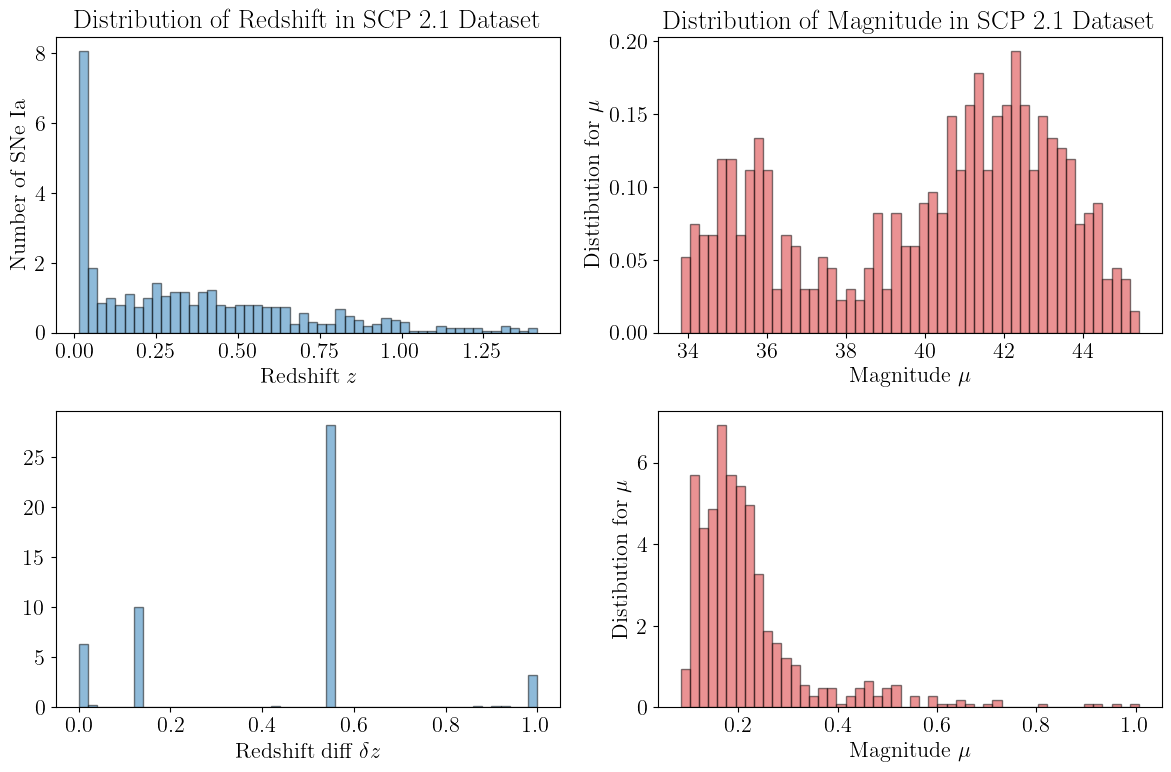

In [51]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

### Defining some useful functions  

In [52]:
def mu_to_d(mu):
    return 10**((mu - 25) / 5)  # in Mpc

def d_to_mu(d):
    if all(i <= 0  for i in d) == False:
        mu = 5 * np.log10(d) + 25
    else:
        print(f'MIN DISTANCE: {np.min(d)}')
        raise ValueError("Distance must be positive.")
    return mu

def rho_crit(H):
    return 3 * H**2 / (8 * np.pi * G)

def get_Om_lam(lam,H):
    return lam / (3 * H**2)

def get_Om_M(lam,H,Om_k = None):
    if Om_k is not None:
        return 1 - Om_k - get_Om_lam(lam,H)
    else:
        return 1 - get_Om_lam(lam,H)
    
def get_q0(Om_M,Om_lam):
    return Om_M / 2 - Om_lam


def E(theta, z):
    try:
        Om_M = theta[0]
        w = theta[1]
    except:
        Om_M = theta
        w = -1

    Om_lam = 1 - Om_M  # assuming flat universe Om_k=0
    
    return Om_M *(1 + z)**3 + Om_lam * (1 + z)**(3 * (1 + w))


def model(theta, z, H0 = 70):
    d = np.zeros_like(z)
    for i, z_i in enumerate(z):
        z_p = np.linspace(0, z_i, 50)
        d[i] = c * (1 + z_i) * np.trapezoid(y=1/ (H0 * np.sqrt(E(theta, z_p))), x=z_p)

    mu = d_to_mu(d)
    return mu

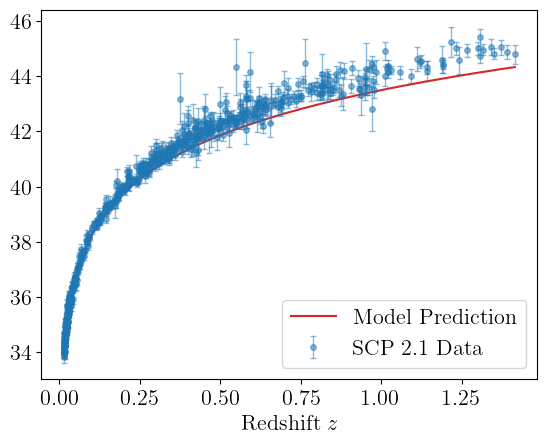

In [53]:
theta0 = [1, -1]    # [Om_M, w]
theta0 = 1
plt.plot(np.sort(z), model(theta0, np.sort(z)), color='tab:red', label='Model Prediction')
plt.errorbar(z, df['mu'], yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.5, label='SCP 2.1 Data', color='tab:blue')
plt.xlabel('Redshift $z$');
plt.legend()

In [ ]:
def log_likelihood(theta, z, mu, sig_mu):
       '''
       Log-likelihood function for supernovae distance moduli.
       Parameters
       ----------
       theta : array-like
                 Model parameters [Om_M, w].
       z : array-like
                 Redshift data.
       mu : array-like
                 Observed distance moduli.
       sig_mu : array-like
                 Uncertainties in distance moduli.
       Returns
       -------
       log_likelihood : float
       '''
       Nd = len(mu)
       resid = mu - model(theta, z)
       W = 1.0 / (sig_mu**2)
       quad = -1/2 * np.sum(resid**2 * W)
       const = -Nd/2 * np.log(2 * np.pi) + 1/2 * np.sum(np.log(W))
       return quad + const

From likelihood
$$
p(\mathcal{D} \mid \theta)
= (2\pi)^{-N_d/2}|W|^{1/2}
\exp\!\Big[-\tfrac{1}{2}(\mathcal{D}-\Phi\theta)^T W(\mathcal{D}-\Phi\theta)\Big]
$$

$$
\begin{aligned}
\log \mathcal{L}(\theta, z, \mu, \sigma_\mu)
&= -\tfrac{1}{2} \Big[ (\mu - \text{model}(\theta, z))^{T} 
\; W \; (\mu - \text{model}(\theta, z)) 
+ N_d \log(2\pi) - \sum_i \log(\sigma_{\mu,i}^2) \Big] \\
\text{where} \quad 
W &= \mathrm{diag}\left( \frac{1}{\sigma_\mu^2} \right)
\end{aligned}
$$

In [55]:
def ml_param(theta0, z=df['z'], mu=df['mu'], dmu=df['mu_err']):
    res = scipy.optimize.minimize(lambda th: -log_likelihood(th, z, mu, dmu), theta0)
    theta_opt = res.x
    return theta_opt

def bic(theta, z, mu, mu_err):
    Np = len(theta)
    Nd = len(mu)
    return 2 * log_likelihood(theta, z, mu, mu_err) - Np * np.log(Nd)

def aic(theta, z, mu, mu_err):
    Np = len(theta)
    return 2 * log_likelihood(theta, z, mu, mu_err) - 2 * Np

In [56]:
theta0 = [1, -1]    # [Om_M, w]
like = log_likelihood(theta0, z, mu, mu_err)

print(model(theta0, z[0:1]))
print('Likelihood:', like)

th_opt_lam = ml_param(theta0=[1, -1])
th_opt_w = ml_param(theta0=1)

print('theta opt M:', th_opt_lam)
print('theta opt w:', th_opt_w)

[35.44711883]
Likelihood: -667.936394680228
theta opt M: [ 0.27965822 -1.0045319 ]
theta opt w: [0.27771576]


In [83]:
grid = 100
Om_M_grid = np.linspace(0,0.5,grid)
w_grid = np.linspace(0,-1.5,grid)

Om_M_g, w_g = np.meshgrid(Om_M_grid,w_grid)

n = 0
like = np.zeros((len(w_grid),len(Om_M_grid)))
sum_like = 0
for w_i,i in zip(w_grid, range(len(w_grid))):
    for Om_M_i,j in zip(Om_M_grid, range(len(Om_M_grid))):
        lh = log_likelihood([Om_M_i,w_i], z, mu, mu_err)
        like[i,j] = np.exp(lh)


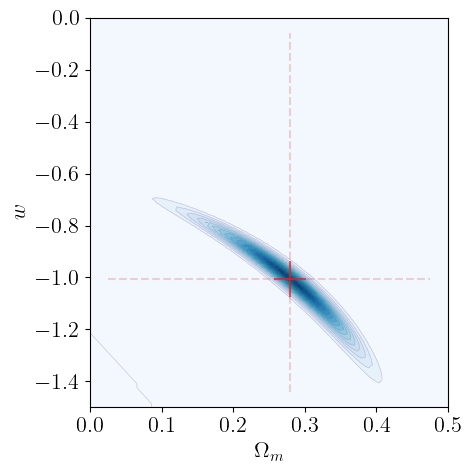

In [88]:
x_opt = th_opt_lam[0]   # Omega_m from lambdaCDM
y_opt = th_opt_lam[1]         # w

# extents
xmin, xmax = np.min(Om_M_g)+0.05*np.max(Om_M_g), np.max(Om_M_g)-0.05*np.max(Om_M_g)
ymin, ymax = np.min(w_g)+0.04*np.max(np.abs(w_g)), np.max(w_g)-0.04*np.max(np.abs(w_g))

dx = 0.05 * (xmax - xmin)
dy = 0.05 * (ymax - ymin)

level = 20

plt.figure(figsize=(5,5))
plt.contour(Om_M_g, w_g, like, levels=level, alpha=0.2, linewidths=0.5)
plt.contourf(Om_M_g, w_g, like, levels=level, cmap='Blues')
# full crosshair (dashed)
plt.vlines(x_opt, ymin=ymin, ymax=ymax, colors='tab:red', linestyles='--', lw=1.5, alpha=0.2)
plt.hlines(y_opt, xmin=xmin, xmax=xmax, colors='tab:red', linestyles='--', lw=1.5, alpha=0.2)

# short tick at the intersection (solid)
plt.vlines(x_opt, ymin=y_opt-dy, ymax=y_opt+dy, colors='tab:red', lw=1.5, alpha=0.7)
plt.hlines(y_opt, xmin=x_opt-dx, xmax=x_opt+dx, colors='tab:red', lw=1.5, alpha=0.7)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$w$')

plt.tight_layout()
# plt.savefig('figs/w_vs_Om_m_1.pdf')

In [101]:
th_opt_w = ml_param(theta0=[1, -1])
print('--- wCDM ---')
print(f'Optimal parameters Om_M, w: {th_opt_w}')
print(f'Optimal parameters Om_lam: {1-th_opt_w[0]}')
print(f'BIC: {bic(th_opt_w, z, mu, mu_err)}')
print(f'AIC: {aic(th_opt_w, z, mu, mu_err)}')

th_opt_lam = ml_param(theta0=1)
print('--- LambdaCDM---')
print(f'Optimal parameters: {th_opt_lam}')
print(f'Optimal parameters Om_lam: {1-th_opt_lam[0]}')
print(f'BIC: {bic([th_opt_lam[0], -1], z, mu, mu_err)}')
print(f'AIC: {aic([th_opt_lam[0], -1], z, mu, mu_err)}')

--- wCDM ---
Optimal parameters Om_M, w: [ 0.27965822 -1.0045319 ]
Optimal parameters Om_lam: 0.7203417762300268
BIC: 224.75546850797429
AIC: 233.48152471505523
--- LambdaCDM---
Optimal parameters: [0.27771576]
Optimal parameters Om_lam: 0.7222842434080371
BIC: 224.7545027535494
AIC: 233.48055896063033


<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_41361/803571592.py:2: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(np.sort(z), model(th_opt_lam, np.sort(z)), color='tab:red', label='Model Prediction: $\Lambda$CDM')


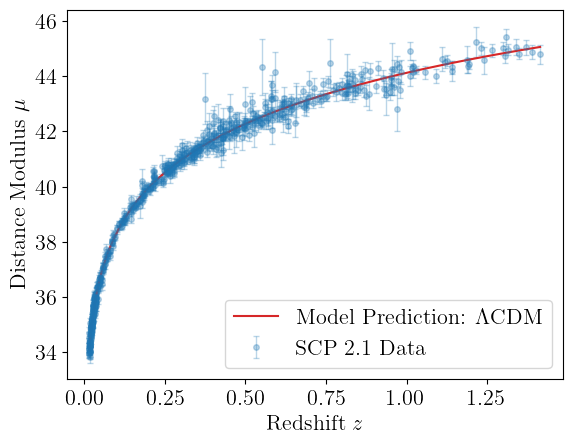

In [102]:
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=4, elinewidth=1, capsize=2, alpha=0.3, label='SCP 2.1 Data', color='tab:blue')
plt.plot(np.sort(z), model(th_opt_lam, np.sort(z)), color='tab:red', label='Model Prediction: $\Lambda$CDM')
plt.xlabel('Redshift $z$');
plt.ylabel('Distance Modulus $\\mu$')
plt.legend()

### Posterior probability for $\Omega_{M,0}$ using $\Lambda\text{CDM}$


In [105]:
# Fix value for w = -1 (LambdaCDM)

def log_prior_OmM(Om_M):
    log_pdf = uniform.logpdf(Om_M, 0, 1)
    return log_pdf

def log_posterior_OmM(theta, z, mu, mu_err):
    Om_M = theta[0]     # fix w = -1
    lp = log_prior_OmM(Om_M)
    ll = log_likelihood([Om_M, -1], z, mu, mu_err)
    return lp + ll

#### MCMC sampling the posterior

In [108]:
def samples_MCMC(theta_lims, function, x, y, sigma, nwalkers, iterations=10000, burninproc=0.10):
    """
    Run emcee for arbitrary parameter vector theta.

    Parameters
    ----------
    theta_lims : list[(low, high)]
        Bounds for each parameter (ndim = len(theta_lims)).
    function : callable
        Log-prob function: function(theta, x, y, sigma) -> logp (float).
    x, y : array-like
        Data.
    sigma : float or array-like
        Known observational uncertainties (as used by `function`).
    nwalkers : int
        Number of walkers (≥ 2*ndim recommended).
    iterations : int, optional
        Number of production steps (after burn-in). Default 10000.
    burnin_frac : float, optional
        Fraction of `iterations` used as burn-in. Default 0.10.
    seed : int, optional
        RNG seed. Default 1337.

    Returns
    -------
    samples : (N, ndim) ndarray
        Flattened chain from production run.
    sampler : emcee.EnsembleSampler
        The sampler (for diagnostics).
    """

    # --- setup
    theta_lims = np.asarray(theta_lims, dtype=float)
    ndim = theta_lims.shape[0]
    rng = np.random.default_rng(1337)

    # --- initialize walkers uniformly within the bounds
    lows  = theta_lims[:, 0]
    highs = theta_lims[:, 1]
    p0 = rng.uniform(lows, highs, size=(nwalkers, ndim))

    # --- burn-in
    burnin = max(1, int(burninproc * iterations))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, function, args=(x, y, sigma))
    p_burn, _, _ = sampler.run_mcmc(p0, burnin, progress=False) # position after burnin

    # --- production
    sampler.reset()
    sampler.run_mcmc(p_burn, iterations, progress=True)
    samples = sampler.get_chain(flat=True)

    return samples, sampler

In [109]:
Om_M_lims = [(0,0.5)]
x = z
y = mu
sigma = mu_err

samples, sampler = samples_MCMC(Om_M_lims, log_posterior_OmM, x, y, sigma, 
                        nwalkers=10, iterations=int(1e3))

/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_41361/2878728177.py:45: RuntimeWarning: invalid value encountered in sqrt
  d[i] = c * (1 + z_i) * np.trapezoid(y=1/ (H0 * np.sqrt(E(theta, z_p))), x=z_p)
100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


In [115]:
samples_arr, sampler = samples
print(len(samples_arr))

10000


Ω_m = 0.2778 (+0.0141, -0.0137)


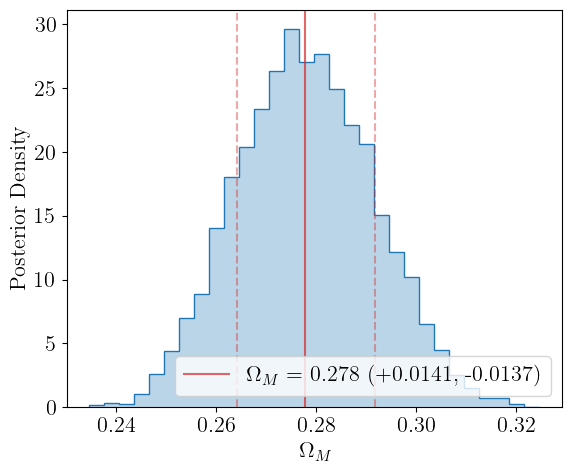

In [ ]:
# compute the percentiles (16th, 50th, 84th)
q16, q50, q84 = np.percentile(samples_arr, [16, 50, 84])
err_low  = q50 - q16
err_high = q84 - q50

print(f"Ω_m = {q50:.4f} (+{err_high:.4f}, -{err_low:.4f})")

# plot
plt.figure(figsize=(6,5))
plt.hist(samples_arr, bins=30, density=True,
         alpha=0.3, color='tab:blue')
plt.hist(samples_arr, bins=30, density=True,
         histtype='step', color='tab:blue', linewidth=1)

# mark median and credible interval
plt.axvline(q50, color='tab:red', linestyle='-', alpha=0.7,
            label=fr"$\Omega_M$ = {q50:.3f} (+{err_high:.4f}, -{err_low:.4f})")
plt.axvline(q16, color='tab:red', alpha=0.4, linestyle='--')
plt.axvline(q84, color='tab:red', alpha=0.4, linestyle='--')


plt.xlabel(r'$\Omega_M$')
plt.ylabel('Posterior Density')
# plt.title('Posterior Distribution for $\Omega_M$ (w = -1)')
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figs/Om_m_posterior.pdf')
